In [ ]:
pip install torch-fidelity wandb

In [ ]:
import os
import shutil
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import torchvision.utils as vutils
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import wandb
from torch_fidelity import calculate_metrics

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [ ]:
config = {
    "dataset": "CIFAR-10",
    "batch_size": 128,
    "epochs": 100,
    "lr": 2e-4,

    "z_dims": [64, 64, 64],
    "kl_weights": [1.0, 0.7, 0.4],
    "base_channels": 128,

    "kl_warmup_epochs": 60,
    "grad_clip": 1.0,

    "fid_every": 5,
    "fid_samples": 1000,
    "kid_subset_size": 300,
}

run_name = f"LVAE_kl_weights_CIFAR10_z{'-'.join(map(str, config['z_dims']))}"
wandb.init(project="generative-modeling-on-cifar-10", name=run_name, config=config)

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: gioeba (gioeba-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])

train_set = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(
    train_set,
    batch_size=config["batch_size"],
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    drop_last=True
)

100%|██████████| 170M/170M [00:01<00:00, 102MB/s]


In [ ]:
real_folder = "/tmp/cifar10_real"
gen_folder = "/tmp/cifar10_gen"
os.makedirs(real_folder, exist_ok=True)
os.makedirs(gen_folder, exist_ok=True)

real_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=T.ToTensor())
if len(os.listdir(real_folder)) == 0:
    for i in tqdm(range(10000), desc="Saving real images"):
        img, _ = real_dataset[i]
        vutils.save_image(img, os.path.join(real_folder, f"real_{i}.png"))

Saving real images: 100%|██████████| 10000/10000 [00:07<00:00, 1297.63it/s]


In [ ]:
LOGVAR_MIN = -6.0
LOGVAR_MAX = 2.0

def clamp_logvar(lv):
    return lv.clamp(LOGVAR_MIN, LOGVAR_MAX)

def kl_diag_gauss(mu_q, logvar_q, mu_p, logvar_p):
    logvar_q = clamp_logvar(logvar_q)
    logvar_p = clamp_logvar(logvar_p)
    var_q = torch.exp(logvar_q)
    var_p = torch.exp(logvar_p)
    kl = 0.5 * ((logvar_p - logvar_q) + (var_q + (mu_q - mu_p) ** 2) / (var_p + 1e-8) - 1.0)
    return kl.sum(dim=1)

def reparam(mu, logvar):
    logvar = clamp_logvar(logvar)
    eps = torch.randn_like(mu)
    return mu + eps * torch.exp(0.5 * logvar)

def precision_merge(mu_hat, logvar_hat, mu_p, logvar_p):
    logvar_hat = clamp_logvar(logvar_hat)
    logvar_p = clamp_logvar(logvar_p)

    var_hat = torch.exp(logvar_hat)
    var_p = torch.exp(logvar_p)

    prec_hat = 1.0 / (var_hat + 1e-8)
    prec_p = 1.0 / (var_p + 1e-8)

    var_q = 1.0 / (prec_hat + prec_p + 1e-8)
    mu_q = (mu_hat * prec_hat + mu_p * prec_p) * var_q
    logvar_q = torch.log(var_q + 1e-8)
    logvar_q = clamp_logvar(logvar_q)
    return mu_q, logvar_q

In [ ]:
class ConvBNAct(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, s=1, p=1):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, k, stride=s, padding=p)
        self.gn = nn.GroupNorm(num_groups=32, num_channels=out_ch)
        self.act = nn.LeakyReLU(0.1, inplace=True)

    def forward(self, x):
        return self.act(self.gn(self.conv(x)))

class UpConvBNAct(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, 4, stride=2, padding=1)
        self.gn = nn.GroupNorm(num_groups=32, num_channels=out_ch)
        self.act = nn.LeakyReLU(0.1, inplace=True)

    def forward(self, x):
        return self.act(self.gn(self.up(x)))

In [ ]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hidden=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Linear(hidden, hidden),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Linear(hidden, out_dim),
        )
    def forward(self, x):
        return self.net(x)

In [ ]:
class LadderVAE(nn.Module):
    def __init__(self, z_dims, base_ch=128):
        super().__init__()
        self.z_dims = z_dims
        self.L = len(z_dims)

        ch1 = base_ch
        ch2 = base_ch * 2
        ch3 = base_ch * 4

        self.enc1 = nn.Sequential(
            ConvBNAct(3, ch1, 3, 1, 1),
            ConvBNAct(ch1, ch1, 4, 2, 1),
            ConvBNAct(ch1, ch1, 3, 1, 1),
        )
        self.enc2 = nn.Sequential(
            ConvBNAct(ch1, ch2, 3, 1, 1),
            ConvBNAct(ch2, ch2, 4, 2, 1),
            ConvBNAct(ch2, ch2, 3, 1, 1),
        )
        self.enc3 = nn.Sequential(
            ConvBNAct(ch2, ch3, 3, 1, 1),
            ConvBNAct(ch3, ch3, 4, 2, 1),
            ConvBNAct(ch3, ch3, 3, 1, 1),
        )

        self.bu_1 = nn.Linear(ch1 * 16 * 16, 2 * z_dims[0])
        self.bu_2 = nn.Linear(ch2 * 8 * 8, 2 * z_dims[1])
        self.bu_3 = nn.Linear(ch3 * 4 * 4, 2 * z_dims[2])

        self.mu_p3 = nn.Parameter(torch.zeros(1, z_dims[2]))
        self.lv_p3 = nn.Parameter(torch.full((1, z_dims[2]), -1.0))
        self.prior_2 = MLP(z_dims[2], 2 * z_dims[1], hidden=256)
        self.prior_1 = MLP(z_dims[1], 2 * z_dims[0], hidden=256)

        self.td_3 = nn.Linear(z_dims[2], ch3 * 4 * 4)
        self.td_2 = nn.Linear(z_dims[1], ch2 * 8 * 8)
        self.td_1 = nn.Linear(z_dims[0], ch1 * 16 * 16)

        self.dec3 = nn.Sequential(ConvBNAct(ch3, ch3, 3, 1, 1))
        self.dec2 = nn.Sequential(UpConvBNAct(ch3, ch2), ConvBNAct(ch2, ch2, 3, 1, 1))
        self.dec1 = nn.Sequential(UpConvBNAct(ch2, ch1), ConvBNAct(ch1, ch1, 3, 1, 1))
        self.dec0 = nn.Sequential(
            UpConvBNAct(ch1, ch1),
            nn.Conv2d(ch1, 3, 3, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        h1 = self.enc1(x)
        h2 = self.enc2(h1)
        h3 = self.enc3(h2)

        bu1 = self.bu_1(h1.flatten(1))
        bu2 = self.bu_2(h2.flatten(1))
        bu3 = self.bu_3(h3.flatten(1))

        mu_hat_1, lv_hat_1 = bu1.chunk(2, dim=1)
        mu_hat_2, lv_hat_2 = bu2.chunk(2, dim=1)
        mu_hat_3, lv_hat_3 = bu3.chunk(2, dim=1)

        B = x.size(0)
        mu_p3 = self.mu_p3.expand(B, -1)
        lv_p3 = self.lv_p3.expand(B, -1)
        mu_q3, lv_q3 = mu_hat_3, lv_hat_3
        z3 = reparam(mu_q3, lv_q3)

        mu_p2, lv_p2 = self.prior_2(z3).chunk(2, dim=1)
        mu_q2, lv_q2 = precision_merge(mu_hat_2, lv_hat_2, mu_p2, lv_p2)
        z2 = reparam(mu_q2, lv_q2)

        mu_p1, lv_p1 = self.prior_1(z2).chunk(2, dim=1)
        mu_q1, lv_q1 = precision_merge(mu_hat_1, lv_hat_1, mu_p1, lv_p1)
        z1 = reparam(mu_q1, lv_q1)

        d3 = self.td_3(z3).view(-1, config["base_channels"] * 4, 4, 4)
        d3 = self.dec3(d3)

        d2 = self.td_2(z2).view(-1, config["base_channels"] * 2, 8, 8)
        d2 = d2 + self.dec2(d3)

        d1 = self.td_1(z1).view(-1, config["base_channels"], 16, 16)
        d1 = d1 + self.dec1(d2)

        x_rec = self.dec0(d1)

        kl3 = kl_diag_gauss(mu_q3, lv_q3, mu_p3, lv_p3)
        kl2 = kl_diag_gauss(mu_q2, lv_q2, mu_p2, lv_p2)
        kl1 = kl_diag_gauss(mu_q1, lv_q1, mu_p1, lv_p1)

        return x_rec, (kl1, kl2, kl3)

    @torch.no_grad()
    def sample(self, n, device):
        mu_p3 = self.mu_p3.expand(n, -1)
        lv_p3 = self.lv_p3.expand(n, -1)
        z3 = reparam(mu_p3, lv_p3)

        mu_p2, lv_p2 = self.prior_2(z3).chunk(2, dim=1)
        z2 = reparam(mu_p2, lv_p2)

        mu_p1, lv_p1 = self.prior_1(z2).chunk(2, dim=1)
        z1 = reparam(mu_p1, lv_p1)

        d3 = self.td_3(z3).view(-1, config["base_channels"] * 4, 4, 4)
        d3 = self.dec3(d3)

        d2 = self.td_2(z2).view(-1, config["base_channels"] * 2, 8, 8)
        d2 = d2 + self.dec2(d3)

        d1 = self.td_1(z1).view(-1, config["base_channels"], 16, 16)
        d1 = d1 + self.dec1(d2)

        x = self.dec0(d1)
        return x

In [ ]:
model = LadderVAE(config["z_dims"], base_ch=config["base_channels"]).to(device)
opt = torch.optim.Adam(model.parameters(), lr=config["lr"])

def kl_warmup_factor(epoch):
    warm = config["kl_warmup_epochs"]
    if warm <= 0:
        return 1.0
    return min(1.0, epoch / warm)

fid_scores, kid_scores, epochs_list = [], [], []

# %% [code]
for epoch in range(1, config["epochs"] + 1):
    model.train()
    beta = kl_warmup_factor(epoch)

    total_loss = total_rec = total_kl1 = total_kl2 = total_kl3 = 0.0

    for x, _ in tqdm(train_loader, desc=f"LVAE Epoch {epoch}/{config['epochs']}"):
        x = x.to(device)

        opt.zero_grad(set_to_none=True)

        x_rec, (kl1, kl2, kl3) = model(x)

        rec = F.l1_loss(x_rec, x, reduction="none").flatten(1).sum(dim=1).mean()
        w1, w2, w3 = config["kl_weights"]
        kl = (w1*kl1 + w2*kl2 + w3*kl3).mean()

        loss = rec + beta * kl
        loss.backward()

        if config["grad_clip"] is not None:
            nn.utils.clip_grad_norm_(model.parameters(), config["grad_clip"])

        opt.step()

        total_loss += loss.item()
        total_rec += rec.item()
        total_kl1 += kl1.mean().item()
        total_kl2 += kl2.mean().item()
        total_kl3 += kl3.mean().item()

    n = len(train_loader)

    wandb.log({
        "lvae/epoch": epoch,
        "lvae/beta_kl": beta,
        "lvae/loss": total_loss / n,
        "lvae/recon": total_rec / n,
        "lvae/kl1": total_kl1 / n,
        "lvae/kl2": total_kl2 / n,
        "lvae/kl3": total_kl3 / n,
        "lvae/kl_total": (total_kl1 + total_kl2 + total_kl3) / n,
    }, step=epoch)

    print(
        f"Epoch {epoch:3d} | "
        f"Loss {total_loss/n:.3f} | "
        f"Recon {total_rec/n:.3f} | "
        f"KL {(total_kl1+total_kl2+total_kl3)/n:.3f} | "
        f"beta {beta:.2f}"
    )

    model.eval()

    with torch.no_grad():
        x, _ = next(iter(train_loader))
        x = x.to(device)
        x_rec, _ = model(x)

    recon_grid = vutils.make_grid(
        torch.cat([x[:16], x_rec[:16]]),
        nrow=16,
        padding=2,
        normalize=True,
        value_range=(-1, 1),
    )

    wandb.log({
        "lvae/reconstructions": wandb.Image(recon_grid.permute(1,2,0).cpu().numpy())
    }, step=epoch)

    if epoch % config["fid_every"] == 0:
        if os.path.exists(gen_folder):
            shutil.rmtree(gen_folder)
        os.makedirs(gen_folder, exist_ok=True)

        with torch.no_grad():
            idx = 0
            while idx < config["fid_samples"]:
                cur_bs = min(64, config["fid_samples"] - idx)
                samples = model.sample(cur_bs, device=device)
                samples = (samples + 1) / 2
                samples = samples.clamp(0, 1)
                for j in range(samples.size(0)):
                    vutils.save_image(samples[j], os.path.join(gen_folder, f"{idx}.png"))
                    idx += 1

        metrics = calculate_metrics(
            input1=gen_folder,
            input2=real_folder,
            fid=True,
            kid=True,
            kid_subset_size=config["kid_subset_size"],
        )

        fid = metrics["frechet_inception_distance"]
        kid = metrics["kernel_inception_distance_mean"]

        fid_scores.append(fid)
        kid_scores.append(kid)
        epochs_list.append(epoch)

        wandb.log({
            "metrics/FID": fid,
            "metrics/KID": kid,
        }, step=epoch)

        print(f"FID: {fid:.2f} | KID: {kid:.5f}")

LVAE Epoch 1/100: 100%|██████████| 390/390 [00:11<00:00, 35.05it/s]

Epoch   1 | Loss 574.484 | Recon 568.033 | KL 503.782 | beta 0.02



LVAE Epoch 2/100: 100%|██████████| 390/390 [00:09<00:00, 42.96it/s]

Epoch   2 | Loss 419.313 | Recon 407.835 | KL 446.756 | beta 0.03



LVAE Epoch 3/100: 100%|██████████| 390/390 [00:09<00:00, 42.73it/s]

Epoch   3 | Loss 371.399 | Recon 352.878 | KL 515.044 | beta 0.05



LVAE Epoch 4/100: 100%|██████████| 390/390 [00:08<00:00, 43.58it/s]

Epoch   4 | Loss 346.148 | Recon 322.195 | KL 503.595 | beta 0.07



LVAE Epoch 5/100: 100%|██████████| 390/390 [00:09<00:00, 40.87it/s]

Epoch   5 | Loss 345.170 | Recon 315.731 | KL 493.204 | beta 0.08



Creating feature extractor "inception-v3-compat" with features ['2048']
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 313MB/s]
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 1000 samples
/usr/local/lib/python3.12/dist-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
Processing samples
Extracting features from input2
Looking for samples non-recursiv

FID: 201.06 | KID: 0.18623


LVAE Epoch 6/100: 100%|██████████| 390/390 [00:09<00:00, 41.78it/s]

Epoch   6 | Loss 337.024 | Recon 302.799 | KL 476.820 | beta 0.10



LVAE Epoch 7/100: 100%|██████████| 390/390 [00:09<00:00, 42.53it/s]

Epoch   7 | Loss 337.476 | Recon 298.637 | KL 463.057 | beta 0.12



LVAE Epoch 8/100: 100%|██████████| 390/390 [00:09<00:00, 41.37it/s]

Epoch   8 | Loss 335.722 | Recon 292.303 | KL 452.013 | beta 0.13



LVAE Epoch 9/100: 100%|██████████| 390/390 [00:09<00:00, 42.47it/s]

Epoch   9 | Loss 336.471 | Recon 289.443 | KL 436.119 | beta 0.15



LVAE Epoch 10/100: 100%|██████████| 390/390 [00:09<00:00, 42.77it/s]

Epoch  10 | Loss 336.863 | Recon 285.896 | KL 425.502 | beta 0.17



Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 1000 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 149.64672256481526
Kernel Inception Distance: 0.1178144121170044 ± 0.00365095109768372


FID: 149.65 | KID: 0.11781


LVAE Epoch 11/100: 100%|██████████| 390/390 [00:08<00:00, 43.39it/s]

Epoch  11 | Loss 337.846 | Recon 283.192 | KL 415.111 | beta 0.18



LVAE Epoch 12/100: 100%|██████████| 390/390 [00:09<00:00, 41.09it/s]

Epoch  12 | Loss 340.413 | Recon 282.200 | KL 405.534 | beta 0.20



LVAE Epoch 13/100: 100%|██████████| 390/390 [00:09<00:00, 42.79it/s]

Epoch  13 | Loss 341.881 | Recon 280.382 | KL 395.906 | beta 0.22



LVAE Epoch 14/100: 100%|██████████| 390/390 [00:09<00:00, 40.56it/s]

Epoch  14 | Loss 343.913 | Recon 279.347 | KL 386.430 | beta 0.23



LVAE Epoch 15/100: 100%|██████████| 390/390 [00:09<00:00, 42.38it/s]

Epoch  15 | Loss 347.548 | Recon 279.893 | KL 378.383 | beta 0.25



Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 1000 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 139.14401754589693
Kernel Inception Distance: 0.11289645433425903 ± 0.0034167632059804156


FID: 139.14 | KID: 0.11290


LVAE Epoch 16/100: 100%|██████████| 390/390 [00:09<00:00, 41.37it/s]

Epoch  16 | Loss 351.724 | Recon 280.413 | KL 373.298 | beta 0.27



LVAE Epoch 17/100: 100%|██████████| 390/390 [00:09<00:00, 41.99it/s]

Epoch  17 | Loss 354.605 | Recon 281.016 | KL 363.432 | beta 0.28



LVAE Epoch 18/100: 100%|██████████| 390/390 [00:09<00:00, 42.51it/s]

Epoch  18 | Loss 353.229 | Recon 278.166 | KL 352.454 | beta 0.30



LVAE Epoch 19/100: 100%|██████████| 390/390 [00:09<00:00, 41.60it/s]

Epoch  19 | Loss 353.916 | Recon 276.846 | KL 344.342 | beta 0.32



LVAE Epoch 20/100: 100%|██████████| 390/390 [00:09<00:00, 43.02it/s]

Epoch  20 | Loss 354.127 | Recon 275.508 | KL 335.729 | beta 0.33



Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 1000 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 139.34008814168476
Kernel Inception Distance: 0.12255578517913818 ± 0.004368219815200782


FID: 139.34 | KID: 0.12256


LVAE Epoch 21/100: 100%|██████████| 390/390 [00:09<00:00, 42.92it/s]

Epoch  21 | Loss 357.051 | Recon 277.504 | KL 325.741 | beta 0.35



LVAE Epoch 22/100: 100%|██████████| 390/390 [00:09<00:00, 39.93it/s]

Epoch  22 | Loss 359.811 | Recon 278.754 | KL 318.184 | beta 0.37



LVAE Epoch 23/100: 100%|██████████| 390/390 [00:09<00:00, 42.93it/s]

Epoch  23 | Loss 358.195 | Recon 276.486 | KL 309.369 | beta 0.38



LVAE Epoch 24/100: 100%|██████████| 390/390 [00:09<00:00, 40.55it/s]

Epoch  24 | Loss 357.908 | Recon 276.378 | KL 299.040 | beta 0.40



LVAE Epoch 25/100: 100%|██████████| 390/390 [00:09<00:00, 42.80it/s]

Epoch  25 | Loss 361.153 | Recon 278.233 | KL 292.995 | beta 0.42



Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 1000 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 138.66234661540358
Kernel Inception Distance: 0.12395849704742432 ± 0.004571840763586268


FID: 138.66 | KID: 0.12396


LVAE Epoch 26/100: 100%|██████████| 390/390 [00:09<00:00, 43.12it/s]

Epoch  26 | Loss 361.161 | Recon 277.822 | KL 285.414 | beta 0.43



LVAE Epoch 27/100: 100%|██████████| 390/390 [00:09<00:00, 41.20it/s]

Epoch  27 | Loss 359.895 | Recon 276.788 | KL 277.036 | beta 0.45



LVAE Epoch 28/100: 100%|██████████| 390/390 [00:09<00:00, 41.79it/s]

Epoch  28 | Loss 364.219 | Recon 279.500 | KL 272.722 | beta 0.47



LVAE Epoch 29/100: 100%|██████████| 390/390 [00:09<00:00, 42.29it/s]

Epoch  29 | Loss 366.174 | Recon 280.596 | KL 267.234 | beta 0.48



LVAE Epoch 30/100: 100%|██████████| 390/390 [00:10<00:00, 36.02it/s]

Epoch  30 | Loss 366.940 | Recon 281.310 | KL 260.631 | beta 0.50



Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 1000 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 137.81082328799903
Kernel Inception Distance: 0.12375741243362427 ± 0.005536490235508802


FID: 137.81 | KID: 0.12376


LVAE Epoch 31/100: 100%|██████████| 390/390 [00:09<00:00, 42.27it/s]

Epoch  31 | Loss 365.645 | Recon 280.645 | KL 253.161 | beta 0.52



LVAE Epoch 32/100: 100%|██████████| 390/390 [00:09<00:00, 42.69it/s]

Epoch  32 | Loss 367.914 | Recon 282.340 | KL 248.143 | beta 0.53



LVAE Epoch 33/100: 100%|██████████| 390/390 [00:09<00:00, 41.69it/s]

Epoch  33 | Loss 366.329 | Recon 280.331 | KL 243.687 | beta 0.55



LVAE Epoch 34/100: 100%|██████████| 390/390 [00:09<00:00, 40.87it/s]

Epoch  34 | Loss 367.729 | Recon 281.699 | KL 238.274 | beta 0.57



LVAE Epoch 35/100: 100%|██████████| 390/390 [00:09<00:00, 41.05it/s]

Epoch  35 | Loss 369.643 | Recon 282.851 | KL 234.545 | beta 0.58



Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 1000 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 139.2644644597869
Kernel Inception Distance: 0.13319802522659302 ± 0.006350597297207417


FID: 139.26 | KID: 0.13320


LVAE Epoch 36/100: 100%|██████████| 390/390 [00:09<00:00, 41.78it/s]

Epoch  36 | Loss 368.072 | Recon 280.541 | KL 231.285 | beta 0.60



LVAE Epoch 37/100: 100%|██████████| 390/390 [00:09<00:00, 40.19it/s]

Epoch  37 | Loss 370.613 | Recon 282.465 | KL 227.521 | beta 0.62



LVAE Epoch 38/100: 100%|██████████| 390/390 [00:09<00:00, 43.03it/s]

Epoch  38 | Loss 372.823 | Recon 284.131 | KL 223.775 | beta 0.63



LVAE Epoch 39/100: 100%|██████████| 390/390 [00:09<00:00, 42.71it/s]

Epoch  39 | Loss 373.240 | Recon 283.901 | KL 220.703 | beta 0.65



LVAE Epoch 40/100: 100%|██████████| 390/390 [00:09<00:00, 41.58it/s]

Epoch  40 | Loss 373.527 | Recon 283.754 | KL 217.383 | beta 0.67



Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 1000 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 136.59826661447704
Kernel Inception Distance: 0.12951602458953856 ± 0.005739937653753052


FID: 136.60 | KID: 0.12952


LVAE Epoch 41/100: 100%|██████████| 390/390 [00:10<00:00, 37.77it/s]

Epoch  41 | Loss 375.193 | Recon 284.592 | KL 214.617 | beta 0.68



LVAE Epoch 42/100: 100%|██████████| 390/390 [00:09<00:00, 42.20it/s]

Epoch  42 | Loss 375.477 | Recon 284.145 | KL 212.045 | beta 0.70



LVAE Epoch 43/100: 100%|██████████| 390/390 [00:09<00:00, 42.97it/s]

Epoch  43 | Loss 377.554 | Recon 285.319 | KL 209.703 | beta 0.72



LVAE Epoch 44/100: 100%|██████████| 390/390 [00:09<00:00, 42.46it/s]

Epoch  44 | Loss 378.714 | Recon 286.144 | KL 206.607 | beta 0.73



LVAE Epoch 45/100: 100%|██████████| 390/390 [00:10<00:00, 38.69it/s]

Epoch  45 | Loss 379.500 | Recon 286.257 | KL 204.258 | beta 0.75



Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 1000 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 134.70886112273757
Kernel Inception Distance: 0.12521315097808838 ± 0.00561998710451121


FID: 134.71 | KID: 0.12521


LVAE Epoch 46/100: 100%|██████████| 390/390 [00:09<00:00, 39.88it/s]

Epoch  46 | Loss 380.395 | Recon 286.469 | KL 201.923 | beta 0.77



LVAE Epoch 47/100: 100%|██████████| 390/390 [00:09<00:00, 42.59it/s]

Epoch  47 | Loss 381.912 | Recon 287.273 | KL 199.652 | beta 0.78



LVAE Epoch 48/100: 100%|██████████| 390/390 [00:09<00:00, 42.46it/s]

Epoch  48 | Loss 383.160 | Recon 288.027 | KL 197.261 | beta 0.80



LVAE Epoch 49/100: 100%|██████████| 390/390 [00:09<00:00, 41.27it/s]

Epoch  49 | Loss 384.657 | Recon 289.010 | KL 194.856 | beta 0.82



LVAE Epoch 50/100: 100%|██████████| 390/390 [00:09<00:00, 43.01it/s]

Epoch  50 | Loss 385.898 | Recon 289.267 | KL 193.331 | beta 0.83



Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 1000 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 129.99907951365793
Kernel Inception Distance: 0.11724856615066528 ± 0.0046902946652179


FID: 130.00 | KID: 0.11725


LVAE Epoch 51/100: 100%|██████████| 390/390 [00:09<00:00, 41.66it/s]

Epoch  51 | Loss 386.826 | Recon 289.804 | KL 190.934 | beta 0.85



LVAE Epoch 52/100: 100%|██████████| 390/390 [00:09<00:00, 42.97it/s]

Epoch  52 | Loss 387.412 | Recon 289.671 | KL 189.275 | beta 0.87



LVAE Epoch 53/100: 100%|██████████| 390/390 [00:09<00:00, 42.86it/s]

Epoch  53 | Loss 388.823 | Recon 290.571 | KL 187.205 | beta 0.88



LVAE Epoch 54/100: 100%|██████████| 390/390 [00:09<00:00, 41.66it/s]

Epoch  54 | Loss 389.837 | Recon 290.871 | KL 185.512 | beta 0.90



LVAE Epoch 55/100: 100%|██████████| 390/390 [00:09<00:00, 42.02it/s]

Epoch  55 | Loss 391.257 | Recon 291.545 | KL 183.852 | beta 0.92



Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 1000 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 131.36517497545816
Kernel Inception Distance: 0.11918819189071655 ± 0.005233204953323583


FID: 131.37 | KID: 0.11919


LVAE Epoch 56/100: 100%|██████████| 390/390 [00:09<00:00, 42.18it/s]

Epoch  56 | Loss 392.270 | Recon 291.967 | KL 182.104 | beta 0.93



LVAE Epoch 57/100: 100%|██████████| 390/390 [00:09<00:00, 42.38it/s]

Epoch  57 | Loss 393.676 | Recon 292.771 | KL 180.411 | beta 0.95



LVAE Epoch 58/100: 100%|██████████| 390/390 [00:09<00:00, 42.49it/s]

Epoch  58 | Loss 394.409 | Recon 292.714 | KL 179.017 | beta 0.97



LVAE Epoch 59/100: 100%|██████████| 390/390 [00:09<00:00, 42.65it/s]

Epoch  59 | Loss 396.134 | Recon 293.888 | KL 177.250 | beta 0.98



LVAE Epoch 60/100: 100%|██████████| 390/390 [00:08<00:00, 43.55it/s]

Epoch  60 | Loss 397.152 | Recon 294.323 | KL 175.685 | beta 1.00



Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 1000 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 131.80070376736938
Kernel Inception Distance: 0.12073950052261352 ± 0.005886514596838571


FID: 131.80 | KID: 0.12074


LVAE Epoch 61/100: 100%|██████████| 390/390 [00:09<00:00, 42.66it/s]

Epoch  61 | Loss 395.981 | Recon 293.265 | KL 175.765 | beta 1.00



LVAE Epoch 62/100: 100%|██████████| 390/390 [00:09<00:00, 42.77it/s]

Epoch  62 | Loss 395.658 | Recon 293.121 | KL 175.683 | beta 1.00



LVAE Epoch 63/100: 100%|██████████| 390/390 [00:09<00:00, 43.14it/s]

Epoch  63 | Loss 394.576 | Recon 292.231 | KL 175.608 | beta 1.00



LVAE Epoch 64/100: 100%|██████████| 390/390 [00:09<00:00, 42.38it/s]

Epoch  64 | Loss 393.819 | Recon 291.533 | KL 175.703 | beta 1.00



LVAE Epoch 65/100: 100%|██████████| 390/390 [00:09<00:00, 41.70it/s]

Epoch  65 | Loss 393.688 | Recon 291.512 | KL 175.706 | beta 1.00



Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 1000 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 130.26211130434547
Kernel Inception Distance: 0.12066933870315552 ± 0.005349969542474247


FID: 130.26 | KID: 0.12067


LVAE Epoch 66/100: 100%|██████████| 390/390 [00:09<00:00, 42.07it/s]

Epoch  66 | Loss 393.288 | Recon 291.255 | KL 175.720 | beta 1.00



LVAE Epoch 67/100: 100%|██████████| 390/390 [00:09<00:00, 42.49it/s]

Epoch  67 | Loss 391.997 | Recon 289.929 | KL 175.935 | beta 1.00



LVAE Epoch 68/100: 100%|██████████| 390/390 [00:09<00:00, 41.44it/s]

Epoch  68 | Loss 391.856 | Recon 289.889 | KL 175.945 | beta 1.00



LVAE Epoch 69/100: 100%|██████████| 390/390 [00:09<00:00, 41.17it/s]

Epoch  69 | Loss 391.704 | Recon 289.897 | KL 175.773 | beta 1.00



LVAE Epoch 70/100: 100%|██████████| 390/390 [00:09<00:00, 41.73it/s]

Epoch  70 | Loss 391.499 | Recon 289.843 | KL 175.719 | beta 1.00



Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 1000 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 126.51940237606652
Kernel Inception Distance: 0.11246009111404419 ± 0.005086277304262418


FID: 126.52 | KID: 0.11246


LVAE Epoch 71/100: 100%|██████████| 390/390 [00:09<00:00, 41.46it/s]

Epoch  71 | Loss 390.796 | Recon 289.175 | KL 175.792 | beta 1.00



LVAE Epoch 72/100: 100%|██████████| 390/390 [00:09<00:00, 42.02it/s]

Epoch  72 | Loss 389.592 | Recon 287.971 | KL 175.995 | beta 1.00



LVAE Epoch 73/100: 100%|██████████| 390/390 [00:09<00:00, 42.66it/s]

Epoch  73 | Loss 388.654 | Recon 287.082 | KL 176.098 | beta 1.00



LVAE Epoch 74/100: 100%|██████████| 390/390 [00:09<00:00, 41.02it/s]

Epoch  74 | Loss 389.117 | Recon 287.671 | KL 175.976 | beta 1.00



LVAE Epoch 75/100: 100%|██████████| 390/390 [00:09<00:00, 42.52it/s]

Epoch  75 | Loss 387.484 | Recon 285.942 | KL 176.386 | beta 1.00



Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 1000 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 129.372187129542
Kernel Inception Distance: 0.1164047122001648 ± 0.005399026620791981


FID: 129.37 | KID: 0.11640


LVAE Epoch 76/100: 100%|██████████| 390/390 [00:09<00:00, 41.38it/s]

Epoch  76 | Loss 388.057 | Recon 286.736 | KL 176.063 | beta 1.00



LVAE Epoch 77/100: 100%|██████████| 390/390 [00:09<00:00, 42.29it/s]

Epoch  77 | Loss 387.980 | Recon 286.710 | KL 176.024 | beta 1.00



LVAE Epoch 78/100: 100%|██████████| 390/390 [00:09<00:00, 40.81it/s]

Epoch  78 | Loss 386.237 | Recon 284.881 | KL 176.417 | beta 1.00



LVAE Epoch 79/100: 100%|██████████| 390/390 [00:09<00:00, 41.93it/s]

Epoch  79 | Loss 386.344 | Recon 285.096 | KL 176.402 | beta 1.00



LVAE Epoch 80/100: 100%|██████████| 390/390 [00:09<00:00, 41.18it/s]

Epoch  80 | Loss 386.002 | Recon 284.773 | KL 176.494 | beta 1.00



Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 1000 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 130.22091026956537
Kernel Inception Distance: 0.11607538461685181 ± 0.004464288394844816


FID: 130.22 | KID: 0.11608


LVAE Epoch 81/100: 100%|██████████| 390/390 [00:09<00:00, 41.50it/s]

Epoch  81 | Loss 386.012 | Recon 284.875 | KL 176.422 | beta 1.00



LVAE Epoch 82/100: 100%|██████████| 390/390 [00:09<00:00, 43.02it/s]

Epoch  82 | Loss 384.809 | Recon 283.619 | KL 176.642 | beta 1.00



LVAE Epoch 83/100: 100%|██████████| 390/390 [00:09<00:00, 42.00it/s]

Epoch  83 | Loss 384.358 | Recon 283.260 | KL 176.648 | beta 1.00



LVAE Epoch 84/100: 100%|██████████| 390/390 [00:09<00:00, 40.21it/s]

Epoch  84 | Loss 383.626 | Recon 282.450 | KL 176.874 | beta 1.00



LVAE Epoch 85/100: 100%|██████████| 390/390 [00:09<00:00, 41.68it/s]

Epoch  85 | Loss 383.707 | Recon 282.551 | KL 176.983 | beta 1.00



Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 1000 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 129.0892969888435
Kernel Inception Distance: 0.1123528552055359 ± 0.004950386991609884


FID: 129.09 | KID: 0.11235


LVAE Epoch 86/100: 100%|██████████| 390/390 [00:09<00:00, 42.40it/s]

Epoch  86 | Loss 383.487 | Recon 282.503 | KL 176.776 | beta 1.00



LVAE Epoch 87/100: 100%|██████████| 390/390 [00:09<00:00, 41.31it/s]

Epoch  87 | Loss 382.673 | Recon 281.592 | KL 177.150 | beta 1.00



LVAE Epoch 88/100: 100%|██████████| 390/390 [00:09<00:00, 40.84it/s]

Epoch  88 | Loss 382.735 | Recon 281.769 | KL 177.034 | beta 1.00



LVAE Epoch 89/100: 100%|██████████| 390/390 [00:09<00:00, 40.25it/s]

Epoch  89 | Loss 382.089 | Recon 281.060 | KL 177.188 | beta 1.00



LVAE Epoch 90/100: 100%|██████████| 390/390 [00:09<00:00, 42.30it/s]

Epoch  90 | Loss 381.787 | Recon 280.862 | KL 177.223 | beta 1.00



Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 1000 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 127.01265335069894
Kernel Inception Distance: 0.1132899785041809 ± 0.005930389680296027


FID: 127.01 | KID: 0.11329


LVAE Epoch 91/100: 100%|██████████| 390/390 [00:09<00:00, 42.47it/s]

Epoch  91 | Loss 380.329 | Recon 279.312 | KL 177.474 | beta 1.00



LVAE Epoch 92/100: 100%|██████████| 390/390 [00:09<00:00, 43.19it/s]

Epoch  92 | Loss 381.905 | Recon 281.070 | KL 177.146 | beta 1.00



LVAE Epoch 93/100: 100%|██████████| 390/390 [00:09<00:00, 41.38it/s]

Epoch  93 | Loss 380.435 | Recon 279.485 | KL 177.477 | beta 1.00



LVAE Epoch 94/100: 100%|██████████| 390/390 [00:09<00:00, 40.31it/s]

Epoch  94 | Loss 379.903 | Recon 279.062 | KL 177.420 | beta 1.00



LVAE Epoch 95/100: 100%|██████████| 390/390 [00:09<00:00, 42.86it/s]

Epoch  95 | Loss 380.126 | Recon 279.259 | KL 177.527 | beta 1.00



Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 1000 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 123.70215601195423
Kernel Inception Distance: 0.1055161452293396 ± 0.0042776318526403494


FID: 123.70 | KID: 0.10552


LVAE Epoch 96/100: 100%|██████████| 390/390 [00:09<00:00, 42.08it/s]

Epoch  96 | Loss 379.333 | Recon 278.371 | KL 177.794 | beta 1.00



LVAE Epoch 97/100: 100%|██████████| 390/390 [00:09<00:00, 42.18it/s]

Epoch  97 | Loss 378.580 | Recon 277.709 | KL 177.810 | beta 1.00



LVAE Epoch 98/100: 100%|██████████| 390/390 [00:09<00:00, 42.79it/s]

Epoch  98 | Loss 378.868 | Recon 278.029 | KL 177.798 | beta 1.00



LVAE Epoch 99/100: 100%|██████████| 390/390 [00:09<00:00, 41.83it/s]

Epoch  99 | Loss 377.968 | Recon 277.129 | KL 177.895 | beta 1.00



LVAE Epoch 100/100: 100%|██████████| 390/390 [00:09<00:00, 41.76it/s]

Epoch 100 | Loss 377.930 | Recon 277.101 | KL 177.973 | beta 1.00



Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 1000 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 122.31705323034748
                                                                                 

FID: 122.32 | KID: 0.10369


Kernel Inception Distance: 0.1036869740486145 ± 0.004840973973480468


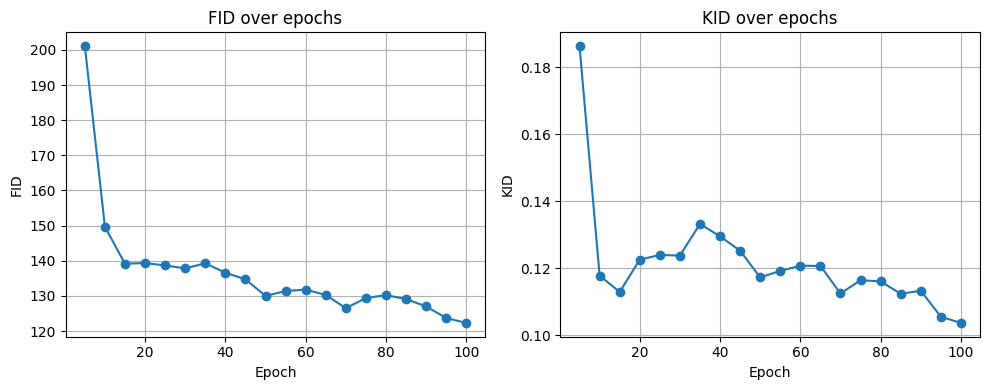

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_list, fid_scores, marker="o")
plt.title("FID over epochs")
plt.xlabel("Epoch")
plt.ylabel("FID")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_list, kid_scores, marker="o")
plt.title("KID over epochs")
plt.xlabel("Epoch")
plt.ylabel("KID")
plt.grid(True)

plt.tight_layout()
plt.show()

wandb.log({"FID_KID_curves": wandb.Image(plt.gcf())})

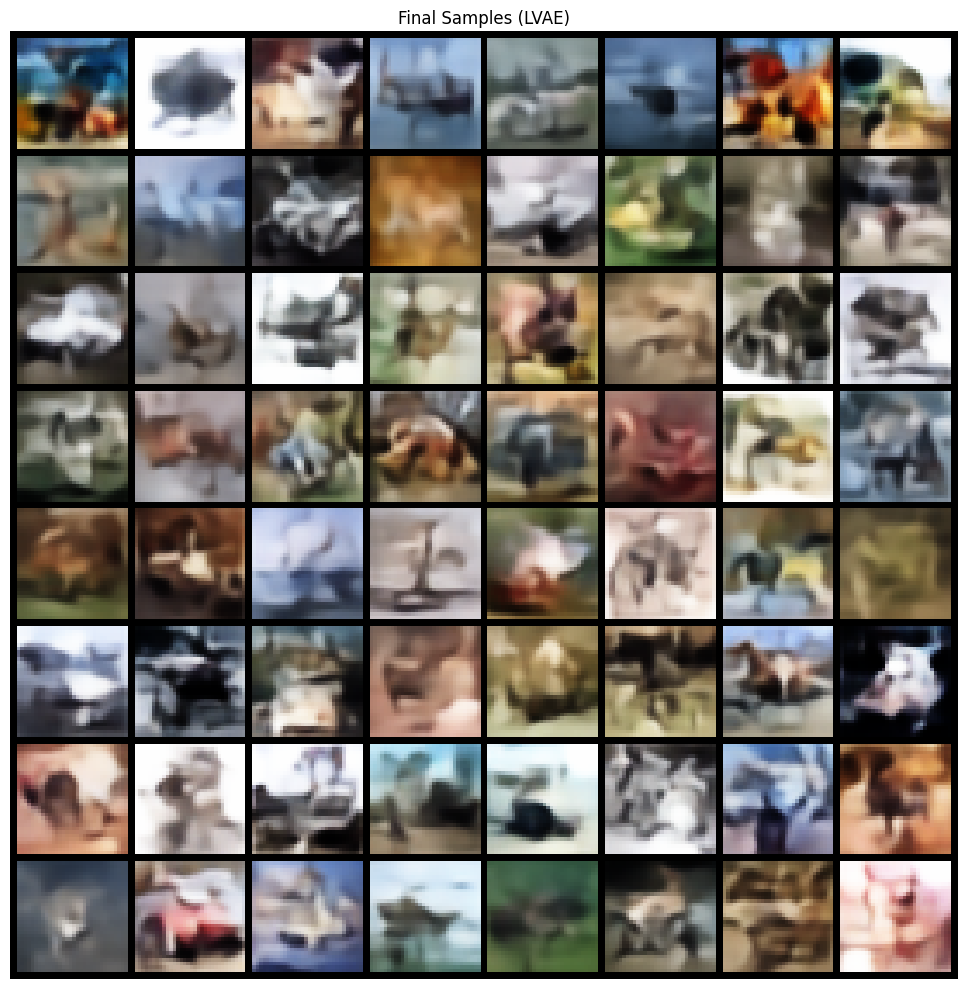

lvae/beta_kl,▁▁▁▁▂▃▃▃▄▄▄▅▅▅▅▅▅▆▆▇▇▇██████████████████
lvae/epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
lvae/kl1,████▇▇▇▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lvae/kl2,█▇▇▆▅▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lvae/kl3,▁█▇▇▆▅▅▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
lvae/kl_total,███▇▆▆▅▅▅▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lvae/loss,█▂▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂
lvae/recon,█▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
metrics/FID,█▃▂▃▂▂▃▂▂▂▂▂▂▁▂▂▂▁▁▁
metrics/KID,█▂▂▃▃▃▄▃▃▂▂▂▂▂▂▂▂▂▁▁
lvae/beta_kl,1


In [ ]:
model.eval()
with torch.no_grad():
    final_samples = model.sample(64, device=device)
    final_samples = (final_samples + 1) / 2
    final_samples = final_samples.clamp(0, 1)

grid = vutils.make_grid(final_samples, nrow=8, padding=2)

wandb.log({
    "samples/generated_final": wandb.Image(
        grid.permute(1,2,0).cpu().numpy(),
        caption="Final LVAE samples"
    )
})

plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0).cpu())
plt.axis("off")
plt.title("Final Samples (LVAE)")
plt.tight_layout()
plt.show()

wandb.finish()